In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

data=pd.read_csv('train_covid.csv')

"""
mean_hh_cli_ct                                            4784 non-null   float64
pct_worried_finances                                      0 non-null      float64
pct_cmnty_cli                                             4804 non-null   float64

"""
#date不是一個特徵值，除非使用OrdinalEncoder，轉換成數列
#如果test的data是未來的這個特徵值，我認為不是一個好的分類指標
#而pct_worried_finances都是NaN可以直接drop掉
data=data.drop(["date","pct_worried_finances"],axis=1)

#分割feature和label
length=data.shape[1]
X=data.iloc[:,0:length-1]
y=data.iloc[:,length-1]

# Data Prepare


## Use SimpleImputer 將nan用中位數替換

In [5]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#因為前三個欄位為str的type
X_num=X.iloc[:,3:]
#去掉不是float的feature
X_num=imp_mean.fit_transform(X_num)

X.iloc[:,3:]=X_num
#確認是否nan都替換掉
X.isna().sum().sum()

0

## Split data 將x split按feature的type(object 和 float) 才可以正確使用演算法

In [ ]:
X_cat=X.iloc[:,]

## Using Different oversampler method

In [6]:

from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=[0,1,2], random_state=0)
X, y = smote_nc.fit_resample(X, y)

# ros = RandomOverSampler(random_state=0)
# X, y = ros.fit_resample(X, y)


## Using Different undersampler method

In [96]:
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(categorical_features=[0,1,2],random_state=0)
# X_resampled, y_resampled = cc.fit_resample(X, y)

## test_condition_分布隨日期變化

In [97]:
# for i in range(1000,5000,500):  
#     y=data.iloc[i:,length-1]
#     plt.hist(y,bins=10)
#     filename="test_condition_分布隨日期變化\ 最後{}".format(5000-i)
#     plt.savefig(filename) 
#     plt.close()  

## OneHotEncoder

In [98]:
from sklearn.compose import make_column_selector as selector
#將是type 是object的取出來:categorical_columns取出來的index
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)


In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [100]:
X_cat=X[categorical_columns]

#onehotencoder使用 -> fit -> transform -> return array 
enc =OneHotEncoder(sparse=False)
enc.fit(X_cat)
data_encoded=enc.transform(X_cat)
#產生columns index的名稱
columns_encoded = enc.get_feature_names(categorical_columns)
X_categorical_columns=pd.DataFrame(data_encoded, columns=columns_encoded)

X_withoutcategorical_columns=X.drop(categorical_columns,axis=1)

X=pd.concat([X_withoutcategorical_columns, X_categorical_columns], axis=1)
#onehotencoder之後


## Using Combination of over- and under-sampling method

In [101]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=0)
# X, y = smote_enn.fit_resample(X, y)

(array([1268.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1471.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

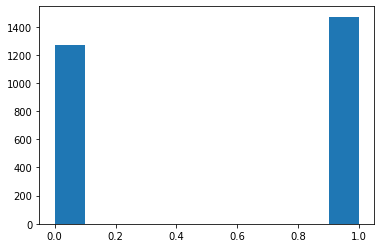

In [102]:
plt.hist(y,bins=10)

## Training Model : X,y

In [103]:

from sklearn.metrics import mean_absolute_error
import xgboost as xgb
clf = xgb.XGBClassifier(objective= 'binary:logistic',eval_metric=mean_absolute_error,
    tree_method="gpu_hist",enable_categorical=True, use_label_encoder=False,
    seed=42)



# __Make Pipeline__

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
pipe = Pipeline([
                    
                 ('scaler', StandardScaler()),
                
                ('min_max', preprocessing.MinMaxScaler(feature_range=(1, 1000))),
                ('feature_select',SelectKBest(chi2)),
                ('clf',clf)
                  ])
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'min_max', 'feature_select', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'min_max__clip', 'min_max__copy', 'min_max__feature_range', 'feature_select__k', 'feature_select__score_func', 'clf__objective', 'clf__use_label_encoder', 'clf__base_score', 'clf__booster', 'clf__colsample_bylevel', 'clf__colsample_bynode', 'clf__colsample_bytree', 'clf__enable_categorical', 'clf__gamma', 'clf__gpu_id', 'clf__importance_type', 'clf__interaction_constraints', 'clf__learning_rate', 'clf__max_delta_step', 'clf__max_depth', 'clf__min_child_weight', 'clf__missing', 'clf__monotone_constraints', 'clf__n_estimators', 'clf__n_jobs', 'clf__num_parallel_tree', 'clf__predictor', 'clf__random_state', 'clf__reg_alpha', 'clf__reg_lambda', 'clf__scale_pos_weight', 'clf__subsample', 'clf__tree_method', 'clf__validate_parameters', 'clf__verbosity', 'clf__eval_metric', 'clf__seed'])

## param_grid setting

In [110]:
from sklearn.model_selection import ShuffleSplit
# 參數篩選
feature_select__k=[100]#50,100,150,200 中
# 
param_grid = { 
    
    'feature_select__k':feature_select__k,
    'clf__learning_rate': [0.05], 
    'clf__max_depth': [6], # 2,4,6中 6最好
    'clf__min_child_weight': [11],# 11,20,30中 11最好
    
    'clf__subsample': [0.8],#0.4,0.8中 0.8最好
    'clf__colsample_bytree': [0.7],
    'clf__n_estimators': [1000], #1000,2000,3000,4000,5000中 5000最好 越多越好
    "clf__gamma":[0.2] # 0.1,0.2,0.3中 0.2最好
    
}
# GridSearchCV : refit==True 會重新用整個data重新訓練一次
gs=GridSearchCV(estimator=pipe,
               param_grid=param_grid,
               
            #    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=0),
               cv=5,
               n_jobs = -1,
              )
gs=gs.fit(X,y)

c:\Users\Ian\Python_workspace\pyml\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


[02:10:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Store best_params_


In [111]:
# param_grid=gs.best_params_
# type(param_grid)
# for i in param_grid.keys():
#     param_grid[i]=[param_grid[i]]
# print(param_grid)
print(gs.best_params_)
print(gs.best_score_)

df=pd.DataFrame(gs.cv_results_)
print(df)
# df.to_excel("xgboost_cv_results.xlsx")

{'clf__colsample_bytree': 0.7, 'clf__gamma': 0.2, 'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__min_child_weight': 11, 'clf__n_estimators': 1000, 'clf__subsample': 0.8, 'feature_select__k': 100}
nan
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      19.761203      0.355713         0.020186         0.00229   

  param_clf__colsample_bytree param_clf__gamma param_clf__learning_rate  \
0                         0.7              0.2                     0.05   

  param_clf__max_depth param_clf__min_child_weight param_clf__n_estimators  \
0                    6                          11                    1000   

   ... param_feature_select__k  \
0  ...                     100   

                                              params split0_test_score  \
0  {'clf__colsample_bytree': 0.7, 'clf__gamma': 0...          0.830292   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0            0.89781           0.930657           

# 輸入test data

In [112]:

test=pd.read_csv("test_covid.csv")

"""
mean_hh_cli_ct                                            4784 non-null   float64
pct_worried_finances                                      0 non-null      float64
pct_cmnty_cli                                             4804 non-null   float64

"""
# test=test.drop(['date', 'state_code', 'gender', 'age_bucket',"mean_hh_cli_ct","pct_worried_finances","pct_cmnty_cli"],axis=1)

test=test.drop(["date","pct_worried_finances"],axis=1)
test.shape

(906, 94)

## Use SimpleImputer 將nan用中位數替換

In [113]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#因為前三個欄位為str的type
test_num=test.iloc[:,3:]
test_num=imp_mean.fit_transform(test_num)
test.iloc[:,3:]=test_num
#確認是否nan都替換掉
test.isna().sum().sum()

0

## OneHotEncoder  還要再確認是否一致

In [1]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(test)

X_test=test.iloc[:,0:test.shape[1]-1]

#onehotencoder使用 -> fit -> transform -> return array 
enc_test =OneHotEncoder(sparse=False)
enc_test.fit(X_test[categorical_columns])
data_encoded=enc_test.transform(X_test[categorical_columns])

#產生columns index的名稱
columns_encoded = enc_test.get_feature_names(categorical_columns)
X_categorical_columns=pd.DataFrame(data_encoded, columns=columns_encoded)

X_withoutcategorical_columns=X_test.drop(categorical_columns,axis=1)
#為了讓onehotencoder 的種類一樣
X_test=pd.concat([X_withoutcategorical_columns, X_categorical_columns], axis=1)
#onehotencoder之後
X_test.head()
X_test.columns
X_test=pd.DataFrame(X_test,columns=X.columns)
print(X_test.isna().sum().sum())
X_test=X_test.fillna(0)
print(X_test.isna().sum().sum())
X_test

NameError: name 'selector' is not defined

# test data 訓練

In [116]:
y_test=gs.best_estimator_.predict(X_test)

col=['test_condition']
df=pd.DataFrame(y_test,columns=col)
df.to_csv('xgboost_combinesampling_SMOTENC_ShuffleSplit.csv', index = True,index_label='id') 


In [59]:
y.shape

(906,)

In [57]:
y_test.shape

(906,)